In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GRU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping

def preprocess_data(data):
    # Unpack data
    X_train_valid = data['X_train_valid']
    y_train_valid = data['y_train_valid']
    X_test = data['X_test']
    y_test = data['y_test']

    # One-hot Encoding for y data
    encoder = LabelBinarizer()
    y_train_valid = encoder.fit_transform(y_train_valid)
    y_test = encoder.fit_transform(y_test)

    # Splitting training and validation data
    X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)

    total_y_train = y_train
    total_y_val = y_val
    total_y_test = y_test

    # Trim
    X_train = X_train[:,:,0:800]
    X_val = X_val[:,:,0:800]
    X_test = X_test[:,:,0:800]

    # Maxpooling
    total_X_train = np.max(X_train.reshape(X_train.shape[0], X_train.shape[1], -1, 4), axis=3)
    total_X_val = np.max(X_val.reshape(X_val.shape[0], X_val.shape[1], -1, 4), axis=3)
    total_X_test = np.max(X_test.reshape(X_test.shape[0], X_test.shape[1], -1, 4), axis=3)

    # Validation and Test Data augmentation stops here (reshaping purposes)
    # Averaging and Subsampling below only apply to Training Data

    # Average every 4 time dumps
    X_train_average = np.mean(X_train.reshape(X_train.shape[0], X_train.shape[1], -1, 4), axis=3)
    X_train_average += np.random.normal(0.0, 0.5, X_train_average.shape)
    total_X_train = np.vstack((total_X_train, X_train_average))
    total_y_train = np.vstack((total_y_train, y_train))

    # Subsample every 4 time dumps
    for i in range(0, 4):
        X_train_subsample = X_train[:,:,i::4] + np.random.normal(0.0, 0.5, X_train[:,:,i::4].shape)
        total_X_train = np.vstack((total_X_train, X_train_subsample))
        total_y_train = np.vstack((total_y_train, y_train))

    return {'total_X_train': total_X_train, 'total_X_val': total_X_val, 'total_X_test': total_X_test, 'total_y_train': total_y_train, 'total_y_val': total_y_val, 'total_y_test': total_y_test}

# Load original data
data = dict()
X_train_valid = np.load("data/X_train_valid.npy")
y_train_valid = np.load("data/y_train_valid.npy")
X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")
person_train_valid = np.load("data/person_train_valid.npy")
person_test = np.load("data/person_test.npy")
data['X_train_valid'] = X_train_valid
data['y_train_valid'] = y_train_valid
data['X_test'] = X_test
data['y_test'] = y_test
data['person_train_valid'] = person_train_valid
data['person_test'] = person_test
preprocessed_data = preprocess_data(data)

# Load preprocessed data
X_train = preprocessed_data['total_X_train']
y_train = preprocessed_data['total_y_train']
X_val = preprocessed_data['total_X_val']
y_val = preprocessed_data['total_y_val']
X_test = preprocessed_data['total_X_test']
y_test = preprocessed_data['total_y_test']
X_train = np.transpose(X_train, (0, 2, 1))
X_val = np.transpose(X_val, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(10152, 200, 22)
(10152, 4)
(423, 200, 22)
(423, 4)
(443, 200, 22)
(443, 4)


In [95]:
CNN_GRU = Sequential()

CNN_GRU.add(Conv1D(22, 10, input_shape=(X_train.shape[1], X_train.shape[2]),padding='same', kernel_regularizer=l2(0.025)))
CNN_GRU.add(MaxPooling1D(2))
CNN_GRU.add(Dropout(0.5))
CNN_GRU.add(Conv1D(22, 10, input_shape=(X_train.shape[1]/2, X_train.shape[2]),padding='same', kernel_regularizer=l2(0.025)))
CNN_GRU.add(MaxPooling1D(2))
CNN_GRU.add(Dropout(0.5))
CNN_GRU.add(Conv1D(22, 10, input_shape=(X_train.shape[1]/2, X_train.shape[2]),padding='same', kernel_regularizer=l2(0.025)))
CNN_GRU.add(Dropout(0.5))
CNN_GRU.add(GRU(44, kernel_regularizer=l2(0.01), return_sequences=True))
CNN_GRU.add(Dropout(0.5))
CNN_GRU.add(Flatten())
CNN_GRU.add(Dense(64))
CNN_GRU.add(Dropout(0.5))
CNN_GRU.add(Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

CNN_GRU.compile(optimizer=optimizer, loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

CNN_GRU.summary()
print("Model compiled.")

/Users/wonjinlee/anaconda3/envs/ECEC147/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_45 (Conv1D)              │ (None, 200, 22)        │         4,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_44 (MaxPooling1D) │ (None, 100, 22)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 100, 22)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 100, 22)        │         4,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_45 (MaxPooling1D) │ (None, 50, 22)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 50, 22)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 50, 22)         │         4,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 50, 22)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_20 (GRU)                    │ (None, 50, 44)         │         8,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 50, 44)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 2200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │       140,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,686 (643.30 KB)

 Trainable params: 164,686 (643.30 KB)

 Non-trainable params: 0 (0.00 B)

Model compiled.


Epoch 1/125


/Users/wonjinlee/anaconda3/envs/ECEC147/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:559: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - accuracy: 0.2512 - loss: 5.6173 - val_accuracy: 0.3121 - val_loss: 3.6811
Epoch 2/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 610ms/step - accuracy: 0.2573 - loss: 5.0587 - val_accuracy: 0.3191 - val_loss: 3.5427
Epoch 3/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 706ms/step - accuracy: 0.2680 - loss: 4.7004 - val_accuracy: 0.3381 - val_loss: 3.4534
Epoch 4/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 660ms/step - accuracy: 0.2946 - loss: 4.2343 - val_accuracy: 0.3641 - val_loss: 3.3647
Epoch 5/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 842ms/step - accuracy: 0.2813 - loss: 4.0548 - val_accuracy: 0.3452 - val_loss: 3.2362
Epoch 6/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 786ms/step - accuracy: 0.2827 - loss: 3.9015 - val_accuracy: 0.3428 - val_loss: 3.1914
Epoch 7/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 773ms/step - accuracy: 0.2922 - loss: 3.6817 - val_accuracy: 0.3452 - val_loss: 3.1613
Epoch 8/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 533ms/step - accuracy: 0.2967 - loss: 3.4796 - val_accuracy:

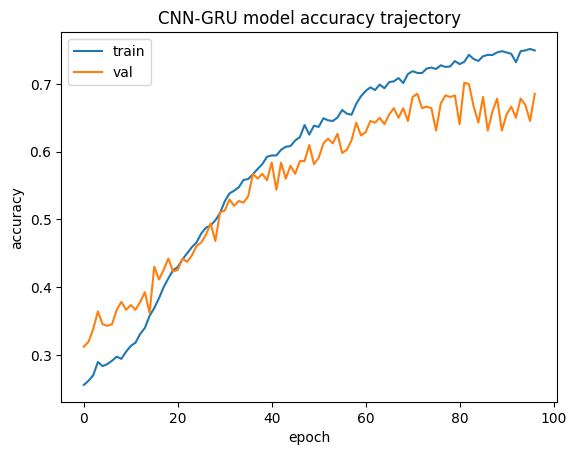

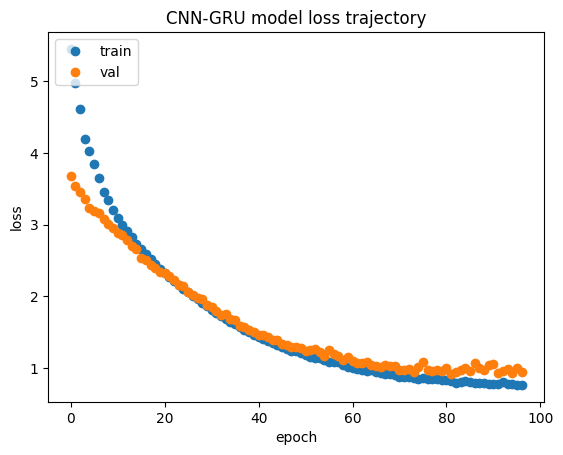

In [96]:
CNN_GRU_results = CNN_GRU.fit(X_train, y_train, epochs=125, batch_size=640, validation_data=(X_val, y_val), shuffle=True, verbose=1, callbacks=[early_stopping])

# Plotting accuracy trajectory
plt.plot(CNN_GRU_results.history['accuracy'])
plt.plot(CNN_GRU_results.history['val_accuracy'])
plt.title('CNN-GRU model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(CNN_GRU_results.history['loss'],'o')
plt.plot(CNN_GRU_results.history['val_loss'],'o')
plt.title('CNN-GRU model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [97]:
## Testing the model
CNN_GRU_score = CNN_GRU.evaluate(X_test, y_test, verbose=0)
print('Test accuracy of the final hybrid CNN-GRU model:',CNN_GRU_score[1])

Test accuracy of the final hybrid CNN-GRU model: 0.715575635433197


In [98]:
CNN_GRU.save('ConvGRU_best.h5')